# What is transfer learning ?

*Transfer learning is a machine learning method where we reuse a pre-trained model as the starting point for a model on a new task.*

*To put it simply—a model trained on one task is repurposed on a second, related task as an optimization that allows rapid progress when modeling the second task.*

*By applying transfer learning to a new task, one can achieve significantly higher performance than training with only a small amount of data.*

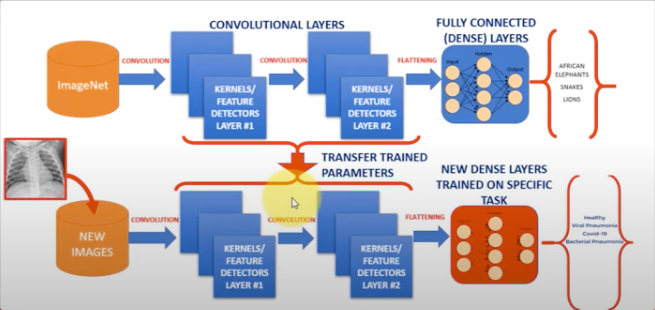

*Dataset download link : https://www.kaggle.com/datasets/ajayrana/hymenoptera-data*

# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import copy
import time
import seaborn as sns
import pandas as pd
from warnings import filterwarnings
filterwarnings('ignore')

# Prepare the dataset and transform

In [2]:
data_transforms = {
    "train":transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.5,1.5)),
    transforms.RandomGrayscale(p=0.5),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),"val":transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224,224)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
    }


In [3]:
data_transforms

{'train': Compose(
     ToTensor()
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
     RandomHorizontalFlip(p=0.5)
     ColorJitter(brightness=(0.5, 1.5), contrast=None, saturation=None, hue=None)
     RandomGrayscale(p=0.5)
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 'val': Compose(
     ToTensor()
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 )}

In [4]:
# Define directories of dataset

DATA_DIR = "hymenoptera_data/"
TRAIN_PATH = os.path.join(DATA_DIR,"train")
VAL_PATH = os.path.join(DATA_DIR,"val")

# Take dataset from folders
train_dataset = datasets.ImageFolder(root=TRAIN_PATH,transform=data_transforms["train"])
val_dataset = datasets.ImageFolder(root=VAL_PATH,transform=data_transforms["val"])


# Describe the Dataset

In [5]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.5, 1.5), contrast=None, saturation=None, hue=None)
               RandomGrayscale(p=0.5)
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [6]:
train_dataset.class_to_idx

{'ants': 0, 'bees': 1}

In [7]:
train_dataset.classes

['ants', 'bees']

In [8]:
train_dataset.imgs[:5]

[('hymenoptera_data/train/ants/0013035.jpg', 0),
 ('hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg', 0),
 ('hymenoptera_data/train/ants/1095476100_3906d8afde.jpg', 0),
 ('hymenoptera_data/train/ants/1099452230_d1949d3250.jpg', 0),
 ('hymenoptera_data/train/ants/116570827_e9c126745d.jpg', 0)]

In [9]:
def dataset_counts(dataset):
    num_ants = 0
    num_bees = 0
    count_list = []
    for i in range(len(dataset)):
        label = dataset.imgs[i][1]
        if label == 0:
            num_ants += 1
            count_list.append(label)
        elif label == 1:
            num_bees += 1
            count_list.append(label)
    print(f"Ants: {num_ants} / Bees: {num_bees}")
            
    return count_list

In [10]:
print(dataset_counts(train_dataset))

Ants: 123 / Bees: 121
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Ants: 123 / Bees: 121


[Text(0, 0, 'ants'), Text(0, 1, 'bees')]

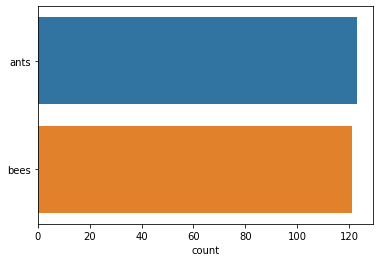

In [11]:
ax = sns.countplot(y=dataset_counts(train_dataset))
ax.set_yticklabels(train_dataset.classes)

Ants: 123 / Bees: 121


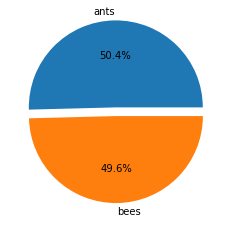

In [12]:
plt.pie(pd.DataFrame(dataset_counts(train_dataset)).value_counts(),
        explode=(0.1,0),autopct="%1.1f%%",labels=train_dataset.classes);

# Load the Dataset

In [13]:
train_loader = DataLoader(dataset=train_dataset,batch_size=4,shuffle=True)
val_loader = DataLoader(dataset=val_dataset,batch_size=4,shuffle=True)

print((len(train_dataset),len(val_dataset)))
print((len(train_loader),len(val_loader)))

(244, 153)
(61, 39)


# Visualize the Images

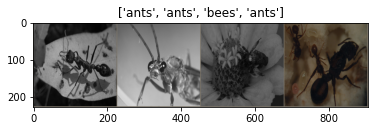

In [14]:
def imshow(inp, title=None):
    # torch.tensor --> (C,H,W)
    # np.array --> (H,W,C)
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))
labels=['ants','bees']

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[labels[x.item()] for x in classes])

In [15]:
im,lbl=next(iter(train_loader))
im.shape

torch.Size([4, 3, 224, 224])

# Use the Pre-Trained Model

In [16]:
import torchvision.models as models

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Load the Resnet model
model=models.resnet18(pretrained=True).to(device)

# Freeze all layers in the neural network
for param in model.parameters():
    param.requires_grad=False  # It freezes the weights.It prevents the computation of derivatives of weights.
    

cpu


In [17]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

**Number of classes --> 2(ants,bees)**

**We change the last layer(fully connected layer) for prediction**

In [19]:
# Get the number of inputs of the last (prediction) layer
in_features = model.fc.in_features

# Reconstruct the prediction layer
model.fc = nn.Linear(in_features=in_features,out_features=2)

# Select devices
model = model.to(device)

# Print changed prediction layer
model.fc

Linear(in_features=512, out_features=2, bias=True)

# Choose Loss Function and Optimizer

In [20]:
LR = 0.001

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1,
                                                      patience=4,
                                                      min_lr=1e-7,
                                                      verbose=True)

In [21]:
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.001,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'params': [0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
    31,
    32,
    33,
    34,
    35,
    36,
    37,
    38,
    39,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    48,
    49,
    50,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58,
    59,
    60,
    61]}]}

# Train the Model

In [22]:
import time

start = time.time()

model = model.to(device)

EPOCHS = 25

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for epoch in range(EPOCHS):
    
    n_correct = 0
    batch_iter = 0
    batch_loss = 0.0

    # Set training mode
    model.train()
    
    for i,(images,labels) in enumerate(train_loader):
        
        # Set devices for dataset to train
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass (Prediction process)
        output = model(images)
        
        # Compute loss value
        loss_val = loss_fn(output,labels)
        batch_loss += loss_val.item()
        
        
        # Set zero gradients
        optimizer.zero_grad()
        
        # Backward pass
        loss_val.backward()
        
        # Update weights
        optimizer.step()
        
        
        # Prediction results
        _,pred = torch.max(output,1)
        n_correct += (pred==labels).sum().item()
        
        batch_iter += 1
        
    # Append loss and accuracy values for each iteration
    train_loss.append(batch_loss/batch_iter)
    train_acc.append(100*n_correct/len(train_dataset))
    
    # Update scheduler for learning rate
    scheduler.step(train_loss[-1])

    # VALIDATION MODE
    n_correct = 0
    batch_loss = 0.0
    batch_iter = 0
    
    # Set validation mode
    model.eval()
    
    with torch.no_grad():
        for i,(images,labels) in enumerate(val_loader):

            # Set devices for dataset to validation
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass (Prediction process)
            output = model(images)

            # Compute loss value
            loss_val = loss_fn(output,labels)
            batch_loss += loss_val.item()

            #Get predicted results
            _,pred=torch.max(output,1)
            n_correct += (pred==labels).sum().item()

            batch_iter+=1

        # Append loss and accuracy values for each iteration
        val_loss.append(batch_loss/batch_iter)
        val_acc.append(100*n_correct/len(val_dataset))
        

        print(f"Epoch[{epoch+1}/{EPOCHS}] , Train Loss:{train_loss[-1]:.3f} , Train Accuracy:{train_acc[-1]:.3f}")
        print("Epoch {}/{} Validation Loss: {:.3f},Validation Acc: {:.3f}".format(
                    epoch+1,EPOCHS,val_loss[-1],val_acc[-1]))
        
        # Current learning rate
        current_lr = optimizer.state_dict()['param_groups'][0]['lr']
        print(f"Learning Rate : {current_lr}")
        print("-------------------------------")
        

end = time.time()

print("Model Training Time : %.2f" % (end-start))

Epoch[1/25] , Train Loss:0.659 , Train Accuracy:61.066
Epoch 1/25 Validation Loss: 0.533,Validation Acc: 73.203
Learning Rate : 0.001
-------------------------------
Epoch[2/25] , Train Loss:0.549 , Train Accuracy:72.541
Epoch 2/25 Validation Loss: 0.290,Validation Acc: 91.503
Learning Rate : 0.001
-------------------------------
Epoch[3/25] , Train Loss:0.508 , Train Accuracy:73.770
Epoch 3/25 Validation Loss: 0.259,Validation Acc: 92.810
Learning Rate : 0.001
-------------------------------
Epoch[4/25] , Train Loss:0.406 , Train Accuracy:81.148
Epoch 4/25 Validation Loss: 0.287,Validation Acc: 86.928
Learning Rate : 0.001
-------------------------------
Epoch[5/25] , Train Loss:0.385 , Train Accuracy:82.787
Epoch 5/25 Validation Loss: 0.217,Validation Acc: 92.157
Learning Rate : 0.001
-------------------------------
Epoch[6/25] , Train Loss:0.412 , Train Accuracy:80.328
Epoch 6/25 Validation Loss: 0.196,Validation Acc: 94.118
Learning Rate : 0.001
-------------------------------
Epoc

In [25]:
print(f"{n_correct}/{len(val_dataset)} correct validation prediction")

142/153 correct validation prediction


# Plot the results

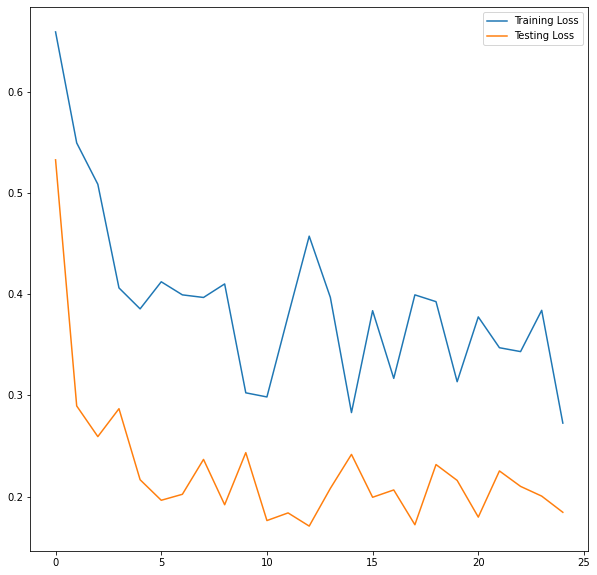

In [27]:
#Plotting the loss
f=plt.figure(figsize=(10,10))
plt.plot(train_loss,label="Training Loss")
plt.plot(val_loss,label="Testing Loss")
plt.legend()
plt.show()

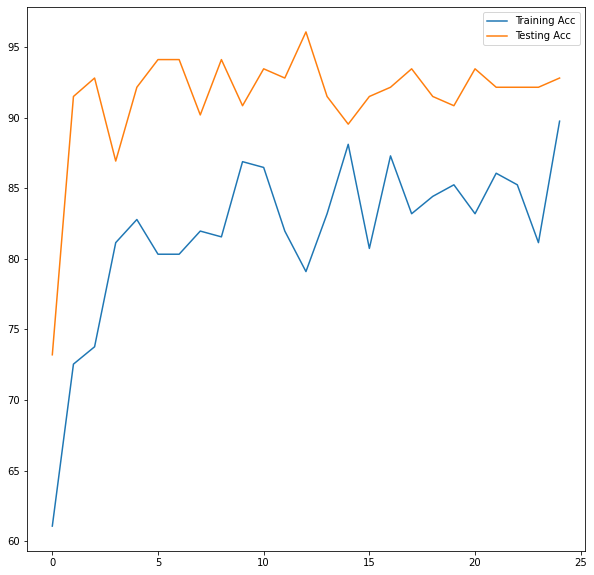

In [28]:
#Plotting the loss
f=plt.figure(figsize=(10,10))
plt.plot(train_acc,label="Training Acc")
plt.plot(val_acc,label="Testing Acc")
plt.legend()
plt.show()

# Save the Model

In [29]:
# Save the Model
torch.save(model,"myModel.pth")

# Save only weights
torch.save(model.state_dict(),"myModel_weights.pth")
print("Saved!!")

Saved!!


# Load the Model

In [30]:
# Load model directly
model = torch.load("myModel.pth")
print("Model loaded succesfully!")

Model loaded succesfully!


In [32]:
# Load model weights (Recommended)
model.load_state_dict(torch.load("myModel_weights.pth"))
print("Model weights loaded succesfully!")

Model weights loaded succesfully!
